In [1]:

import keras
from keras import layers
from keras import ops

import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

# For data preprocessing
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

!gdown "1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t"
!unzip -q instance-level-human-parsing.zip

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:39<00:00, 73.3MB/s]


In [14]:
IMAGE_SIZE = 512
BATCH_SIZE = 16 #v1=4;v2=16
NUM_CLASSES = 20
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50

train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]


def read_image(image_path, mask=False):
    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf_image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf_data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None))>


In [15]:
## Step 3: Define ERFNet Model
from keras import Model
import tensorflow as tf

def residual_block(x, filters):
    """Defines a Factorized Residual Block."""
    residual = x
    x = layers.Conv2D(filters, (1, 3), padding="same", activation="relu")(x)  # Horizontal convolution
    x = layers.Conv2D(filters, (3, 1), padding="same", activation="relu")(x)  # Vertical convolution
    return layers.Add()([x, residual])  # Add residual connection

def downsample_block(x, filters):
    """Defines a Downsampling Block."""
    x = layers.Conv2D(filters, 3, strides=2, padding="same", activation="relu")(x)  # Downsample
    return x

def upsample_block(x, filters):
    """Defines an Upsampling Block."""
    x = layers.Conv2DTranspose(filters, 3, strides=2, padding="same", activation="relu")(x)  # Upsample
    return x

def ERFNet(num_classes=20, input_shape=(256, 256, 3)):
    """Defines the ERFNet architecture."""
    input_layer = tf.keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(16, 3, strides=2, padding="same", activation="relu")(input_layer)  # Initial Downsampling
    x = residual_block(x, 16)
    x = downsample_block(x, 64)
    x = residual_block(x, 64)
    x = downsample_block(x, 128)
    x = residual_block(x, 128)

    # Decoder
    x = upsample_block(x, 64)
    x = residual_block(x, 64)
    x = upsample_block(x, 16)
    x = residual_block(x, 16)

    # Added another upsampling layer to match the input size
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)

    # Output Layer
    output_layer = layers.Conv2D(num_classes, 1, activation="softmax")(x)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer, name="ERFNet")
    return model

# Instantiate the ERFNet model
num_classes = 20  # CIHP dataset has 20 categories
input_shape = (512, 512, 3)  # Example input size
model = ERFNet(num_classes=num_classes, input_shape=input_shape)

model.summary()  # Print model summary to check the architecture

Model: "ERFNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 256, 256, 16)   │            448 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 256, 256, 16)   │            784 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 256, 256, 16)   │            784 │ conv2d_45[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 256, 256, 16)   │              0 │ conv2d_46[0][0],       │
│                           │                        │                │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 128, 128, 64)   │          9,280 │ add_15[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 128, 128, 64)   │         12,352 │ conv2d_47[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 128, 128, 64)   │         12,352 │ conv2d_48[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 128, 128, 64)   │              0 │ conv2d_49[0][0],       │
│                           │                        │                │ conv2d_47[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ add_16[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 64, 64, 128)    │         49,280 │ conv2d_50[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 64, 64, 128)    │         49,280 │ conv2d_51[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_17 (Add)              │ (None, 64, 64, 128)    │              0 │ conv2d_52[0][0],       │
│                           │                        │                │ conv2d_50[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_7        │ (None, 128, 128, 64)   │         73,792 │ add_17[0][0]           │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 128, 128, 64)   │         12,352 │ conv2d_transpose_7[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 128, 128, 64)   │         12,352 │ conv2d_53[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 128, 128, 64)   │              0 │ conv2d_54[0][0],       │
│                      

 Total params: 320,372 (1.22 MB)

 Trainable params: 320,372 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - accuracy: 0.2868 - loss: 2.6866 - val_accuracy: 0.5953 - val_loss: 1.8036
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 0.5761 - loss: 1.8163 - val_accuracy: 0.5958 - val_loss: 1.6558
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.5764 - loss: 1.6836 - val_accuracy: 0.5960 - val_loss: 1.5633
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - accuracy: 0.5765 - loss: 1.6026 - val_accuracy: 0.5960 - val_loss: 1.5315
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 231ms/step - accuracy: 0.5765 - loss: 1.5708 - val_accuracy: 0.5960 - val_loss: 1.4922
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.5765 - loss: 1.5536 - val_accuracy: 0.5960 - val_loss: 1.4699
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.5765 - loss: 1.5248 - val_accuracy: 0.5967 - val_loss: 1.4522
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.5798 - loss: 1.4942 - val_accu

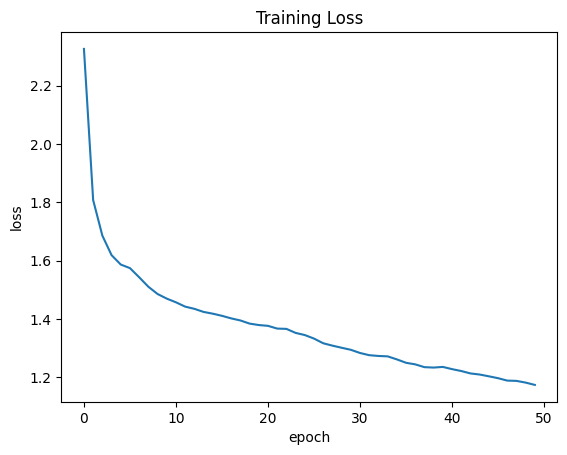

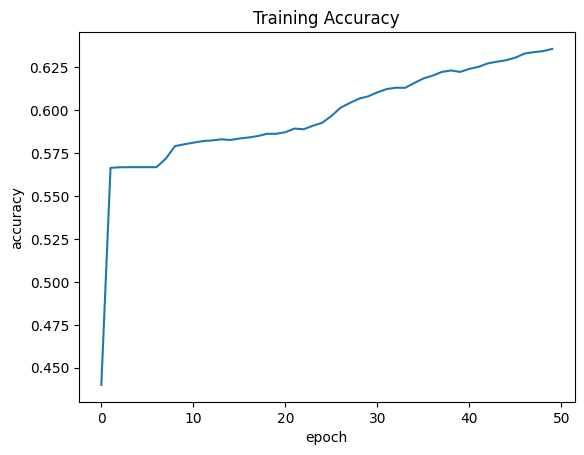

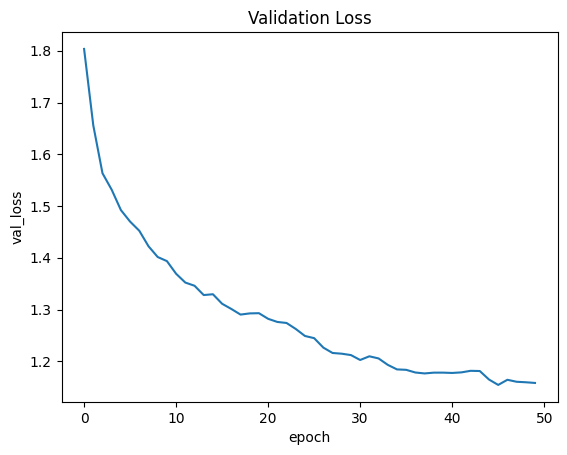

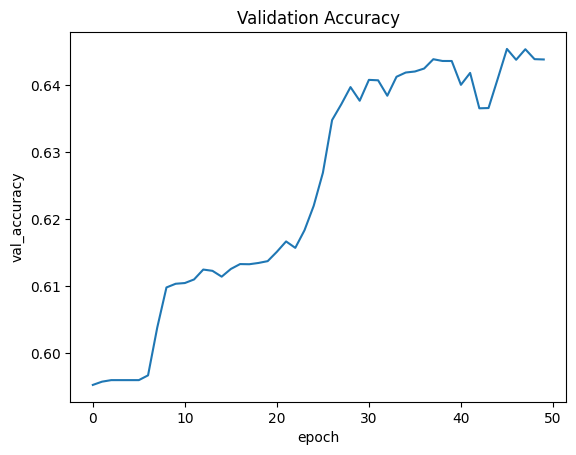

In [16]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=50)  #v1=25;v2=50

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [17]:
model.save('erfnet_model_v2.h5')